# Email Fraud Detection: BERT Model Testing

#### Ross Willett

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Email-Fraud-Detection:-BERT-Model-Testing" data-toc-modified-id="Email-Fraud-Detection:-BERT-Model-Testing-1">Email Fraud Detection: BERT Model Testing</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Ross-Willett" data-toc-modified-id="Ross-Willett-1.0.0.1">Ross Willett</a></span></li></ul></li></ul></li><li><span><a href="#Notebook-Introduction" data-toc-modified-id="Notebook-Introduction-1.1">Notebook Introduction</a></span></li><li><span><a href="#Preparing-the-Data-Set" data-toc-modified-id="Preparing-the-Data-Set-1.2">Preparing the Data Set</a></span></li><li><span><a href="#Loading-and-Testing-the-Model" data-toc-modified-id="Loading-and-Testing-the-Model-1.3">Loading and Testing the Model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.4">Conclusion</a></span></li></ul></li></ul></div>

## Notebook Introduction

In this notebook, the trained fraud email identifier built on the BERT transformer will be loaded and evaluated in terms of performance.

## Preparing the Data Set

In order to test the model, the data set will have to be appropriately separated.

In [134]:
import pandas as pd
import numpy as np

# Import plotting libraries
import matplotlib.pyplot as plt

# Model selection libraries
from sklearn.model_selection import train_test_split

# Model Evaluation Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import Tensor Flow and keras
import tensorflow as tf
from tensorflow import keras

# Import Tensor Flow Hub and Tensor Flow Text (Required libraries for the pre-trained BERT Model)
import tensorflow_hub as hub
import tensorflow_text

In [135]:
# Configure Pandas to show all columns / rows
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
# Set column max width larger
pd.set_option('display.max_colwidth', 1000)

In [136]:
# Load data from phishing email csv
email_df = pd.read_csv('./data/fraud_all_data_clean_4.csv')

In [137]:
# Separate the features into a separate data frame
X = email_df.drop(columns=['fraud'])
# Separate the target into a separate data frame
y = email_df.loc[:, ['fraud']]

In [138]:
# Split the data set into a remainder and test set
X_remainder, X_test, y_remainder, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=1337,
    test_size=0.2,
)
# Reset the indices of the data frames so index counts have the same start
X_remainder.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_remainder.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Loading and Testing the Model

Now that the data has been appropriately separated, the model can now be loaded and used to predict the classification of the test data.

In [139]:
# Load the saved model into Keras
loaded_model = keras.models.load_model(
    './models/bert_model_20_relu_sig.h5',
    custom_objects={'KerasLayer':hub.KerasLayer},
    compile=False,
)

In [140]:
# Add the compilation parameters for the model (Note this must be done since compile has been set to False)
loaded_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()]
)

In [109]:
# Get the model prediction probabilities for the test content
y_test_pred = loaded_model.predict(X_test['content'])

78/78 [==============================] - 333s 4s/step


In [112]:
# Binarize the predictions at a threshold of 50% positive
y_test_bin_pred = np.where(y_test_pred >= 0.4, 1, 0)

In [113]:
# Check the accuracy score of the model
accuracy_score(y_test['fraud'].values, y_test_bin_pred.flatten())

0.9673518742442564

Using a threshold of 40% to indicate if an email is fraudulent or not results in a test accuracy of 96.7% for the BERT model. This is slightly lower than the test accuracy of the best tuned logistic regression model which is 97.3%. Despite the slightly lower accuracy I expect that the BERT model would be better for fraudulent email identification due to the fact it is not as reliant upon specific words and can better identify the context of words. The performance of the BERT model will be further examined by looking at its confusion matrix and the types of emails it incorrectly identifies.

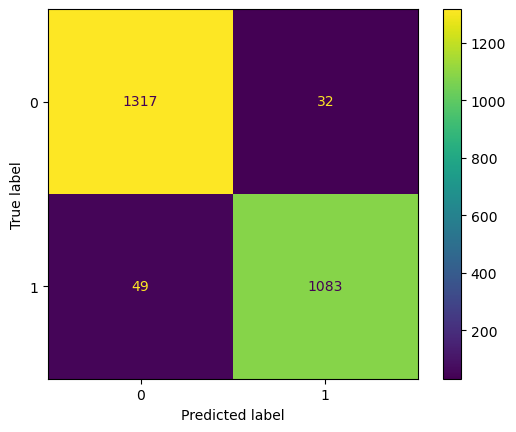

In [114]:
# Initialize the confusion matrix for the model's results
conf_matrix = confusion_matrix(y_test, y_test_bin_pred)
# Initialize the display of the confusion matrix for the model results
conf_disp = ConfusionMatrixDisplay(conf_matrix)
# Plot the confusion matrix
conf_disp.plot()
plt.show()

In [115]:
# Calculate the recall of the model
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]) * 100
# Calculate the precision of the model
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1]) * 100
# Print the precision and recall of the model
print(f'Recall: {recall}%')
print(f'Precision: {precision}%')

Recall: 95.6713780918728%
Precision: 97.13004484304932%


As demonstrated by the confusion matrix above, the recall of the model is 96% and precision is 97%. Without rounding, these numbers are slightly lower than the result of the best logistic regression model. Next, the incorrect categorizations of the model will be examined.

In [125]:
# Get the X values where the predicted value does not equal the test value
wrong_pred = X_test[y_test_bin_pred.flatten() != y_test['fraud']]

In [126]:
# Get the Y values where the predicted value does not equal the test value
wrong_pred_y = y_test[y_test_bin_pred.flatten() != y_test['fraud']]

In [127]:
# Concatinate the data frames with wrong X and Y predictions
wrong_pred = pd.concat([wrong_pred, wrong_pred_y], axis=1)

In [152]:
# Check the false negative predictions
wrong_pred[wrong_pred['fraud'] == 1].sample(10)

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
1377,you must be aware now that my country The Republic of South won the bid to host the world cup by prior to this bid my committee was to lobby the of board of Federation International Association on selection of the country to host the world the bid intensive but at the end we got the hosting right was the sum of million to lobby the of the ruling bo sure that we win the hosting right considering the gain that comes the hosting right like South economy will receive a massive dire boost from hosting the World Cup financial impact report for South World Cup bid committee that the World Cup will pump billion into South my and an new With the help the living of our time year old Peace Prize winner Nelson who made an emotive case for The Republic of South we got the bid without spending all the money I and my committee saw this as a God sent opportunity to secure our future and that of our family therefore wa by other committee to look for a way to move the money to a safe place with the ...,0,0,40,310,1
671,NELSON SMITH KINDLY REPLY ME ON MY PRIVATE ADDRESS yahoo,0,0,1,10,1
2365,if you are interested please write back and I will Keep this confidential as you reach me on yahoo Finally please note that this must be next week I look forward to it Barrister and,0,0,1,35,1
1721,me to the best pharmacy,1,0,2,5,1
1289,Agricultural Research Institute of Northern,0,0,2,5,1
1252,Dear Sir I got your contact from the World Trade of the US Canada Union and I am to interrupt your peace since you are not receive any mail from me However I was obliged to do so due to the importance of the message I crave your indulgence and want you that I mean well and that it is only for good So please do not be embarrassed My name is Mike Hammer I am a social worker with Governmental Voluntary organization based I am the Project Director in the Middle East regional representation through local and other and with the United High Commission works and and social in some third world assistance and re settlement of natural disaster civil and oppressed and minority people around I am just back from where in the cause of we found a huge amount of cash in an I an agreement with the of my are UN and we agreed to keep this money and then the box out of to with their immunity as UN they are not or Now I am in need of a trustworthy person or company overseas whom I work with since my wor...,0,0,2,438,1
851,Your contact information will be for easy communication Warm a a ca,0,0,11,12,1
2161,We Welcome You To Your Offer,0,0,0,6,1
2373,am you believing you are a honest and trustworthy person believe you will not betray the confidence I am willing to repose in you for me to have you even though we not met before name is only son of late who was the chairman Alimentary and ex owner of Polyclinic LA of the Republic of Cote can find the story on this A th of a group of so took over the city of to over throw the Government of the President of Cote On the th day morning at about A am some of the same group of break into our house and our security guard and pass through the gate entrance to the main building and took my father away to an un known destination about four later we found him my father at the road side by then he had been totally beaten and was bleeding to death lying in the pool of his own blood From there we rushed him to a near by hospital and later he sent for my mother So he told her that he can not make it from the diagnosis he also told her that it was because he my father was not from the northern pa...,0,0,79,402,1
941,hurst net enterprise Once you sent a payment to the address at the top of the list along with your note this is VERY important the next thing to do is copy the contents of this page as you be sending it out as an message to at least people although with the legitimate and the different ways of advertising on the the amount of of your mail could well exceed into the o

Looking at the messages the model identified as false negatives, there appears to be two prominent patterns. The first pattern is that the model does not properly flag fraud emails which tend to be lengthy where the sender pretends to be from an obscure organization or government institution. The other type of fraud emails incorrectly identified are those that tend to be short with no strong indicating words and a link for the user to follow. It is possible the length emails could be properly identified by a larger BERT model with more training, but it is unlikely the short emails could be identified without additional code built to feed this information along with the BERT model into a new model.

In [151]:
# Check the false positive predictions
wrong_pred[wrong_pred['fraud'] == 0].sample(10)

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
1887,Does this work for you Statement by the in the men and of the Department of State are mourning the murder of three people connected to Consulate General in One consulate employee was along with and the husband of a employee was also I offer my to the family and of these The safety and security of our personnel and their in and at the world is always our highest priority I have spoken with our Ambassador in and we are working Government of to do everything necessary to protect our people and to ensure that the horrendous are brought to justice These appalling on of our own State Department family are sadly part of a growing tragedy in They underscore the imperative of our continued commitment to work closely with of President to cripple the influence of at work in This is we must shoulder together particularly in border where strong of history common interest bind the and the people closely together,0,0,0,163,0
1818,For your situational awareness,0,0,0,4,0
756,When will you be back so we can catch up Also who is your right hand on all of these I can work your office for a time,0,0,0,28,0
1186,me know if I can be of any help to your department and will happy to do and please on behalf of me and supporting Thank,0,0,14,26,0
724,state with this condolence cable for president He brother after a long illness Dear President Sincerely yours,0,0,4,17,0
618,be careful when this one Also that really cute thing that do of leaving their panties on one leg while making love Dare I ask what a girl is Yahoo Sponsor Free Join Now us click yahoo To from this group send an to Your use of Yahoo is subject to yahoo,2,0,4,52,0
1051,am ARRIVE State Department am PRESIDENTIAL DAILY BRIEFING am Secretary Office am DAILY SMALL STAFF MEETING am Secretary Office am DAILY SENIOR STAFF MEETING am Secretary Conference Room am OFFICE TIME am Secretary Office am PRIVATE MEETING am Secretary Office am BRIEFING ON GLOBAL HEALTH INITIATIVE am Secretary Outer Office am WEEKLY DEVELOPMENT TEAM MEETING Secretary Outer Office OFFICE TIME Secretary Office DEPART State route National Airport ARRIVE National Airport DEPART National Airport via US Shuttle En route New York ARRIVE New York New York Airport DEPART New York route Private Residence ARRIVE Private Residence,0,0,48,95,0
2201,am DEPART Private Residence En mute Hotel am ARRIVE Hotel am MEETING FOREIGN MINISTER Suite am PERSONAL STAFF TIME am Private Suite am MEETING FOREIGN MINISTER am Suite am PERSONAL STAFF TIME am Suite MEETING FOREIGN MINISTER Suite STAFF Suite pin MEETING DEPUTY PRIME MINISTER FOREIGN MINISTER Suite STAFF Suite pin DEPART Hotel En route Airport ARRIVE Airport pin DEPART Airport via US En route Nat Airport ARRIVE National Airport DEPART National Airport En route State Department pin ARRIVE State Department OFFICE TIME Secretary Office PRIVATE MEETING BOB Secretary Office DINNER FOR INCOMING SECRETARY GENERAL pin Room th Floor DEPART State Department En route Private Residence ARRIVE Private Residence,0,0,69,109,0
927,from The Register To from this daily news update see the at the end of this message ADVERTISEMENT WIN to a FORMULA ONE GRAND Group business continuity expert driver of the team Click here to find out more and win For every new customer that between the Grand season Group will grant to a Grand hospitality event with us next season Mandrake go live at Will the public love them content Confirmed to ship up security in Surely not a reason to upgrade from Win You amaze us content Enterprise to pink slip per cent Decimation st century style content Personal Hardware plummet in No Mercy content Mobile spat price underdog content conference in pub Well drink to that content Net Security Security hacker Somebody had to say it content Vuln exposed by Outlook plug In Pretty Poor Privacy content Business part of content Daily Telegraph for libel Very short story content war From mug to smug content lined up

Examining the messages the model falsely identified as fraud reveals several commonalities. The first of these is that many of the messages falsely flagged typical relate to governments or finances. This makes sense since many fraud emails relate to these subjects. In addition to this, some messages which relate to downloading files or opening links have also been falsely flagged. This also makes sense since fraud emails tend to encourage this type of activity to trick victims into providing sensitive information or download viruses. It may be difficult to train a model to differentiate these types of emails from truly fraudulent ones without incorporating information about the sender, but it is possible with more data and training that this could be improved.

In [150]:
loaded_model.predict([
    '''
After the last annual calculation of your fiscal activity we have determined that you are eligible to receive a charge refund of $386.00 CAD.
Please submit the charge refund form and allow us 3-5 business days in order to process it.
A refund can be delayed for a variety of reasons. For example submitting invalid records or applying after the deadline.
To complete your tax return form, please click here>> [LINK to fraudulent website has been disabled.]

NOTE!
For security reasons, we will record your ip-address and date.

Thank you,
Canada Revenue Agency

    '''
])

1/1 [==============================] - 0s 257ms/step


array([[0.8960545]], dtype=float32)

## Conclusion

Despite the fact that the BERT model has slightly worse performance than the best tuned linear regression model, the BERT model is still the model that is recommended for use as a fraud email identifier. This is largely due to the fact that it is much more generally applicable due to its use of word embeddings. This is especially important since criminals who use these fraud schemes constantly change their strategies and if they become aware of specific words causing their emails to be flagged as fraud, they will simply stop using those words. The other advantage the BERT model has is the ability for it to distinguish the context of a word, thus just because a certain word appears, the model will not automatically identify the email as fraud. Thus, this BERT model represents a good start for a model that could be used for classifying an email as fraud or not, solely based on its text content.